In [2]:
import collections as c

%matplotlib inline
import numpy as np
import pandas as pd
import string
from numpy.random import normal,random,seed
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
#import lightgbm as lgb

In [3]:
df = pd.read_csv('clean_data.csv')

df.head(5)

,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,Page_Views,Time_On_Site_Total,Visits,Visitor_Bounce,CPC
0,5/21/2017 0:00,21,39,1,symptoms of asthma,1,2.08,3,51,5.40,2,13,2,1,1.8
1,5/21/2017 0:00,21,39,1,breathing with asthma,1,2.00,1,4,3.71,1,7,1,0,3.71
2,5/21/2017 0:00,21,46,1,asthma inhaler names,1,2.00,1,1,3.58,1,42,1,0,3.58
3,5/21/2017 0:00,21,40,1,breathing problems asthma,1,1.00,1,1,3.24,1,0,1,0,3.24
4,5/21/2017 0:00,21,48,1,asthma inhaler otc,1,1.70,1,3,3.76,1,4,1,0,3.76


In [4]:
##extract most common words to build features - granular

import numpy as np
#categories: asthma Symptom treatment brand chemicals payment age cause


# 1. symptom
df['symptom'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('symptoms', case=False),
        df['KEYWORD'].str.contains('signs', case=False),
        df['KEYWORD'].str.contains('coughing'),
        df['KEYWORD'].str.contains('breathing'),
        df['KEYWORD'].str.contains('inflammation')
    ],
    choicelist=[1, 2, 3, 4, 5], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 2. asthma
df['asthma'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('asthma', case=False),
        df['KEYWORD'].str.contains('asma', case=False),
        df['KEYWORD'].str.contains('asthmatic'),
        df['KEYWORD'].str.contains('asthmas')
    ],
    choicelist=[1, 2, 3, 4], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 3. treatment
df['treatment'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('inhaler|inhalers', case=False),
        df['KEYWORD'].str.contains('dosage|dosing|dose', case=False),
        df['KEYWORD'].str.contains('80|40|mcg|mg'),
        df['KEYWORD'].str.contains('treatment|treatments'),
        df['KEYWORD'].str.contains('side|effects'),
        df['KEYWORD'].str.contains('medications|medication|medicine|medicines', case=False),
        df['KEYWORD'].str.contains('action', case=False),
        df['KEYWORD'].str.contains('plan'),
        df['KEYWORD'].str.contains('inhalation|aerosol'),
        df['KEYWORD'].str.contains('over|otc', case=False),
        df['KEYWORD'].str.contains('relief'),
        df['KEYWORD'].str.contains('control|treat'),
        df['KEYWORD'].str.contains('nasal'),
        df['KEYWORD'].str.contains('use|used')
    ],
    choicelist=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 4. brand
df['brand'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('product1', case=False),
        df['KEYWORD'].str.contains('competitor1', case=False),
        df['KEYWORD'].str.contains('competitor5'),
        df['KEYWORD'].str.contains('competitor7'),
        df['KEYWORD'].str.contains('competitor6'),
        df['KEYWORD'].str.contains('generic'),
        df['KEYWORD'].str.contains('competitor8'),
        df['KEYWORD'].str.contains('product1.com'),
        df['KEYWORD'].str.contains('brands')    
    ],
    choicelist=[1, 2, 3, 4, 5, 6, 7, 8, 9], # dummy variables
    default=0 # you could set it to `np.nan` etc
)
 
# 5. chemical
df['chemical'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('hfa', case=False),
        df['KEYWORD'].str.contains('names', case=False),
        df['KEYWORD'].str.contains('beclomethasone'),
        df['KEYWORD'].str.contains('budesonide'),
        df['KEYWORD'].str.contains('corticosteroid'),
        df['KEYWORD'].str.contains('q|var|quvar')  
    ],
    choicelist=[1, 2, 3, 4, 5, 6], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. payment
df['payment'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('coupon|coupons', case=False),
        df['KEYWORD'].str.contains('copay', case=False),
        df['KEYWORD'].str.contains('patient|assistance'),
        df['KEYWORD'].str.contains('savings|discount'),
        df['KEYWORD'].str.contains('free'),
        df['KEYWORD'].str.contains('cost|price|prices')  
    ],
    choicelist=[1, 2, 3, 4, 5, 6], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. Age
df['age'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('children|child|childhood|kids', case=False),
        df['KEYWORD'].str.contains('adults', case=False)
    ],
    choicelist=[1, 2], # dummy variables
    default=0 # you could set it to `np.nan` etc
)

# 6. cause
df['cause'] = np.select(
    condlist=[ # note you could use the case-insensitive search with `case=False`
        df['KEYWORD'].str.contains('causes|cause', case=False),
        df['KEYWORD'].str.contains('triggers', case=False)
    ],
    choicelist=[1, 2], # dummy variables
    default=0 # you could set it to `np.nan` etc
)




In [79]:
df['logCTR'] = np.log10(df['CTR']+1)
df.head(5)


,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,...,asthma,treatment,brand,chemical,payment,age,cause,CTR,logClicks,logCTR
0,5/21/2017 0:00,21,39,1,symptoms of asthma,1,2.08,3,51,5.40,...,1,0,0,0,0,0,0,0.058824,0.60206,0.024824
1,5/21/2017 0:00,21,39,1,breathing with asthma,1,2.00,1,4,3.71,...,1,0,0,0,0,0,0,0.250000,0.30103,0.096910
2,5/21/2017 0:00,21,46,1,asthma inhaler names,1,2.00,1,1,3.58,...,1,1,0,2,0,0,0,1.000000,0.30103,0.301030
3,5/21/2017 0:00,21,40,1,breathing problems asthma,1,1.00,1,1,3.24,...,1,0,0,0,0,0,0,1.000000,0.30103,0.301030
4,5/21/2017 0:00,21,48,1,asthma inhaler otc,1,1.70,1,3,3.76,...,1,1,0,0,0,0,0,0.333333,0.30103,0.124939


In [18]:
df['logClicks'] = np.log10(df['Clicks']+1)
df.head(5)


,DATE,WEEK_OF_YEAR,CAMPAIGN,CAMPAIGN_TYPE,KEYWORD,NETWORK,POSITION,Clicks,Impressions,Media_Cost,...,symptom,asthma,treatment,brand,chemical,payment,age,cause,CTR,logClicks
0,5/21/2017 0:00,21,39,1,symptoms of asthma,1,2.08,3,51,5.40,...,1,1,0,0,0,0,0,0,0.058824,0.60206
1,5/21/2017 0:00,21,39,1,breathing with asthma,1,2.00,1,4,3.71,...,4,1,0,0,0,0,0,0,0.250000,0.30103
2,5/21/2017 0:00,21,46,1,asthma inhaler names,1,2.00,1,1,3.58,...,0,1,1,0,2,0,0,0,1.000000,0.30103
3,5/21/2017 0:00,21,40,1,breathing problems asthma,1,1.00,1,1,3.24,...,4,1,0,0,0,0,0,0,1.000000,0.30103
4,5/21/2017 0:00,21,48,1,asthma inhaler otc,1,1.70,1,3,3.76,...,0,1,1,0,0,0,0,0,0.333333,0.30103


In [83]:
df_mean = df['logCTR'].mean()
df_mean

0.09428776173802259

In [26]:
#logClicks, w media cost
X = df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR', 'logClicks'], axis=1) 
y=df.loc[:,'logClicks']

In [57]:
#remove media cost
X = df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR', 'logClicks', 'Media_Cost'], axis=1) 
y=df.loc[:,'logClicks']

In [80]:
#y = logCTR, w media cost
X = df.drop(labels=['DATE','WEEK_OF_YEAR','KEYWORD','Impressions','CPC','Page_Views', 'Clicks', 'Time_On_Site_Total','Visits', 'Visitor_Bounce','CTR', 'logClicks', 'logCTR'], axis=1) 
y=df.loc[:,'logCTR']

In [81]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
# Set seed for reproducibility
SEED = 1
# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.3,
random_state=SEED)

In [82]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestRegressor(n_estimators=400,
min_samples_leaf=0.12,
random_state=SEED)
# Fit 'rf' to the training set
rf.fit(X_train, y_train)
# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)
y_pred_train=rf.predict(X_train)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.08


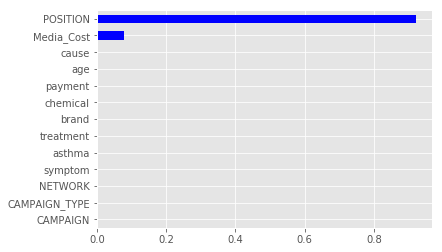

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

In [85]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
rfSearch200 = RandomForestRegressor(n_estimators=200,random_state=0,
                                    oob_score=True,n_jobs=-1,max_features=6)
rfSearch200.fit(X, y)
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

train RMSE = 0.03699825420706523


In [86]:
param = {'objective': 'reg:squarederror'}

In [87]:
dtrain = xgb.DMatrix(X, label=y)

C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\manya\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [88]:
cvSearch = xgb.cv(param, dtrain, nfold = 3,num_boost_round=75,verbose_eval=10)
cvSearch.tail(20)

[0]	train-rmse:0.295993+0.000163824	test-rmse:0.295996+0.000392092
[10]	train-rmse:0.06521+0.000266272	test-rmse:0.066075+0.000142691
[20]	train-rmse:0.062931+0.000197471	test-rmse:0.0643513+0.000231724
[30]	train-rmse:0.061934+0.000105081	test-rmse:0.063802+0.000293197
[40]	train-rmse:0.061166+0.000114377	test-rmse:0.063508+0.000228168
[50]	train-rmse:0.0606247+0.000151377	test-rmse:0.0633667+0.000198048
[60]	train-rmse:0.0600637+0.000144742	test-rmse:0.0632283+0.000226253
[70]	train-rmse:0.0595557+0.000184724	test-rmse:0.0631407+0.000231357
[74]	train-rmse:0.0593423+0.000231943	test-rmse:0.0630873+0.000222295


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
55,0.060310,0.000177,0.063281,0.000181
56,0.060270,0.000189,0.063280,0.000183
57,0.060247,0.000196,0.063271,0.000179
58,0.060193,0.000200,0.063273,0.000181
59,0.060112,0.000140,0.063232,0.000228
60,0.060064,0.000145,0.063228,0.000226
61,0.060021,0.000145,0.063222,0.000235
62,0.059958,0.000154,0.063212,0.000236
63,0.059898,0.000166,0.063206,0.000238
64,0.059856,0.000147,0.063201,0.000239


best number of rounds = 74
rmse = 0.06308733333333333


C:\Users\manya\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


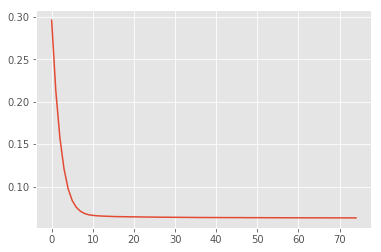

In [89]:
eps = 1e-6
bestNR = np.argmax(cvSearch['test-rmse-mean']<eps+min(cvSearch['test-rmse-mean']))
bestRMSE = cvSearch.loc[bestNR,'test-rmse-mean']
plt.plot(cvSearch['test-rmse-mean'])
print('best number of rounds =',bestNR)
print('rmse =',bestRMSE) #using bestNR

In [90]:
modelSearch = xgb.train(param, dtrain,num_boost_round=bestNR)
print(RMSE(y,modelSearch.predict(xgb.DMatrix(X))))

0.06014989016884585


In [91]:
regSearch = XGBRegressor(objective='reg:squarederror',n_estimators=bestNR)
regSearch.fit(X,y)
print(RMSE(y,regSearch.predict(X)))

0.0688036451649217


In [92]:
regSearch = XGBRegressor(objective='reg:squarederror',n_estimators=bestNR, max_depth=6,
                         learning_rate=0.3)
regSearch.fit(X,y)
print(RMSE(y,regSearch.predict(X)))

0.06014989016884585


In [93]:
# xgboost task parameters
folds = 3

# Parameters grid to search
param_test1 = {
    'learning_rate':[.3,.15,.05],
    'max_depth':[4,5,6],
    'n_estimators':np.append(range(30,90,10),bestNR)
}

In [94]:
grid = GridSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror',
                    nthread=1, seed=0), scoring = 'neg_mean_squared_error',
                    param_grid = param_test1, n_jobs=-1,cv=folds,iid=False)
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'learning_rate': [0.3, 0.15, 0.05], 'max_depth': [4, 5, 6], 'n_estimators': array([30, 40, 50, 60, 70, 80, 74])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [95]:
# summarize results
for mean,param in zip(grid.cv_results_['mean_test_score'],grid.cv_results_['params']):
    print("%f with: " % -mean,param)

0.004481 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 30}
0.004417 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 40}
0.004378 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 50}
0.004344 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 60}
0.004328 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 70}
0.004305 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 80}
0.004318 with:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 74}
0.004370 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 30}
0.004313 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 40}
0.004298 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50}
0.004297 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 60}
0.004298 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 70}
0.004288 with:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 80}
0.004294 with:  {'learnin

In [96]:
print('MSE before tuning: %f' % bestRMSE**2)
print("Best MSE after tuning: %f using %s" % (-grid.best_score_,grid.best_params_))

MSE before tuning: 0.003980
Best MSE after tuning: 0.004258 using {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50}


# ADA Boost

In [97]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# Set seed for reproducibility
SEED = 1
# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = \
train_test_split(X, y,
test_size=0.3,
random_state=SEED)

In [98]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)

In [99]:
# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
ada_y_pred = ada.predict(X_test)

In [100]:
ada_y_pred_train=ada.predict(X_train)
# Evaluate the test set RMSE
ada_rmse_test = MSE(y_test, ada_y_pred)**(1/2)
ada_rmse_train = MSE(y_train, ada_y_pred_train)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))

Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.08


In [101]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5
adaSearch200 = AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)
adaSearch200.fit(X, y)
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

train RMSE = 0.08749820543613263


In [48]:
##values for y = logClicks,w Keywords
print('y=logClicks, including Keyword extractions')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=logClicks, including Keyword extractions
XGBoost
Test set RMSE of rf: 0.21
Train set RMSE of rf: 0.21
train RMSE = 0.04896127457408791
ADABoost
Test set RMSE of rf: 0.18
Train set RMSE of rf: 0.18
train RMSE = 0.19297467333711552


In [78]:
#w/o media cost
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.         0.01822438]
 [0.01822438 1.        ]]
[[1.         0.01507926]
 [0.01507926 1.        ]]
Test set RMSE of rf: 0.32
Train set RMSE of rf: 0.32


In [50]:
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.         0.55503887]
 [0.55503887 1.        ]]
[[1.         0.56285648]
 [0.56285648 1.        ]]
Test set RMSE of rf: 0.21
Train set RMSE of rf: 0.21


In [102]:
##values for y = logCTR,w media cost
print('y=logCTR, including Keyword extractions')
print('XGBoost')
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))
print('train RMSE =',RMSE(y,rfSearch200.predict(X)))

print('ADABoost')
print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))
print('train RMSE =',RMSE(y,adaSearch200.predict(X)))

y=logCTR, including Keyword extractions
XGBoost
Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.08
train RMSE = 0.03699825420706523
ADABoost
Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.08
train RMSE = 0.08749820543613263


In [103]:
##values for y = logCTR,w media cost
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
rmse_train = MSE(y_train, y_pred_train)**(1/2)
#Computer R^2 between y_pred and y_pred_train
R2_train = np.corrcoef(y_train, y_pred_train)**2
R2_test = np.corrcoef(y_test, y_pred)**2

print(R2_train)
print(R2_test)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

[[1.         0.23271201]
 [0.23271201 1.        ]]
[[1.         0.22976256]
 [0.22976256 1.        ]]
Test set RMSE of rf: 0.08
Train set RMSE of rf: 0.08
